# **2D Detection pipeline**
___  
  
In this notebook, we demonstrate the use of the [BiaPy](https://biapyx.github.io/) pipeline for **2D detection** of microscopy data.

<figure>
<center>
<img src='https://github.com/BiaPyX/BiaPy-doc/blob/master/source/img/detection_2d_overview.svg?raw=true' width='400px'/>
<figcaption><b>Figure 1</b>: Example of a 2D detection problem. From left to right: 2D fluorescence image and its corresponding CSV file with the coordinates of the center of each cell. </figcaption></center>
</figure>

Without any coding, we'll guide you step-by-step through the process to:
1. **Upload a set of training and test images** along with their corresponding instance label images.
2. **Train a Deep Neural Network (DNN)** model using the training set.
3. **Apply the model** to the test images.
4. **Download the segmentation results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired by the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!


## **Expected Inputs and Outputs**
___

### **Inputs**

This notebook requires the following five input folders:

- **Training Raw Images**: Consisting of the unprocessed 2D images intended for training.
- **Training CSV Files**: Providing the coordinates for the center of each cell for model training. The number and size of these files should align with the training raw images.
- **Test Raw Images**: Houses the 2D images on which the model will be tested.
- **Test CSV Files**: Contains the coordinates of the centers of the cells for testing. Ensure that their number and sizes correspond to the test raw images.
- **Output Folder**: A designated directory where segmentation results will be saved.

### **Outputs**

On successful execution, an output folder will emerge, containing a **CSV file** and a **TIFF image** for every test image. The CSV files list the coordinates of each cell's center, while the result images depict these central points as deduced by our pipeline.

<font color='red'><b>Note:</b></font> For testing purposes, you can utilize the **example datasets provided under 'Manage File(s) Source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
├── train
│   ├── x
│   │   ├── training-0001.tif
│   │   ├── training-0002.tif
│   │   ├── . . .
│   │   ├── training-9999.tif
│   └── y
│       ├── training_groundtruth-0001.csv
│       ├── training_groundtruth-0002.csv
│       ├── . . .
│       ├── training_groundtruth-9999.csv
└── test
    ├── x
    │   ├── testing-0001.tif
    │   ├── testing-0002.tif
    │   ├── . . .
    │   ├── testing-9999.tif
    └── y
        ├── testing_groundtruth-0001.csv
        ├── testing_groundtruth-0002.csv
        ├── . . .
        ├── testing_groundtruth-9999.csv
```

**⚠️ Warning:** Ensure that images and their corresponding CSV files are sorted in the same way. A common approach is to fill with zeros the image number added to the filenames (as in the example).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).




## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Check for GPU Access**
---

By default, the session is configured to use Python 3 with GPU acceleration. However, it's a good practice to double-check these settings:

1. Navigate to **Runtime** in the top menu and select **Change the Runtime type**.
2. Ensure the following settings:
   - **Runtime type:** Python 3 (This program is written in the Python 3 programming language.)
   - **Accelerator:** GPU (Graphics Processing Unit)

This will ensure that you're using Python 3 and taking advantage of GPU acceleration.

## **Manage File(s) Source**
---

The input folder can be provided using three different options:
1. **Direct Upload**: Directly upload the desired folder.
2. **Google Drive**: Use a folder stored in your Google Drive.
3. **Sample Data**: Use a sample dataset provided by us.

The steps you'll need to follow vary depending on your chosen option. These steps are detailed in the subsequent sections.

### **Option 1: Upload Local Files to the Notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/x
%cd /content/input/train/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload csv files (instance coordinates)

from google.colab import files
!mkdir -p /content/input/train/y
%cd /content/input/train/y
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
!mkdir -p /content/input/test/x
%cd /content/input/test/x
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload csv files (instance coordinates)

from google.colab import files
!mkdir -p /content/input/test/y
%cd /content/input/test/y
uploaded = files.upload()
%cd /content

### **Option 2: Mount Your Google Drive**
---

If you wish to use this notebook with data from your Google Drive, you'll first need to mount the drive to this notebook.

Execute the cell below to initiate the Google Drive mounting process. A link will be displayed click on it. In the new browser window that opens, choose your drive and click 'Allow'. Copy the code that appears, return to this notebook, paste the code into the cell, and press 'Enter'. This action grants Colab access to your Google Drive data.

After this process, you can access your data via the **Files** tab, located on the top left of this notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: Download an Example Dataset**
---
Don't have data readily available but still want to test the notebook? No problem! Simply execute the following cell to download a sample dataset.

Specifically, we'll use the [ZeroCostDL4Mic - Stardist example training and test dataset](https://zenodo.org/record/3715492#.Y4m7FjPMJH6) which is publicly available online. While this dataset is tailored for instance segmentation, we'll generate a CSV file detailing the center of each instance, making it compatible with our workflow.

In [ ]:
#@markdown ##Play to download an example dataset
!pip install gdown==5.1.0 --quiet
import gdown
import os

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=1pWqQhcWY15b5fVLZDkPS-vnE-RU6NlYf", "Stardist_v2_detection.zip", quiet=True)

!unzip -q Stardist_v2_detection.zip
!rm Stardist_v2_detection.zip

print( 'Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `train_data_path` to `/content/input/train/x`
  - Set `train_csv_path` to `/content/input/train/y`
  - Set `test_data_path` to `/content/input/test/x`
  - Set `test_csv_path` to `/content/input/test/y`
  - Set `output_path` to `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
- **Option 3 (Use Our Sample Data)**:
  - Set `train_data_path` to `/content/data/train/x`
  - Set `train_csv_path` to `/content/data/train/y`
  - Set `test_data_path` to `/content/data/test/x`
  - Set `test_csv_path` to `/content/data/test/y`
  - Set `output_path` to `/content/out`

  **Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/data/train/x' #@param {type:"string"}
#@markdown #####Path to train CSV files
train_csv_path = '/content/data/train/y' #@param {type:"string"}
#@markdown #####Path to test images
test_data_path = '/content/data/test/x' #@param {type:"string"}
#@markdown #####Path to test CSV files
test_csv_path = '/content/data/test/y' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output

# Uninstall some packages already installed in Colab for Pytorch 2.1.0
!pip uninstall -y torchtext

!pip install biapy==3.4.6

# Then install Pytorch + CUDA 11.8
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118
!pip install 'timm>=0.9.12' 'torchmetrics>=1.3.0.post0'

from biapy import BiaPy
changed_source = False


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 93.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 92.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

## **Configure and Train the DNN Model**
---

Within this workflow, [BiaPy](https://biapy.readthedocs.io/en/latest/) aims to localize objects in the input image by pinpointing individual central points at their center of mass, as described by [Zhou et. al](https://arxiv.org/abs/1904.07850). To achieve this, we generate a mask utilizing the points listed in the CSV to train the network. The **central_point_dilation** variable determines the size of these central points.


In [ ]:
# @markdown ###OPTIONAL: Check BioImage Model Zoo (BMZ) models compatible with BiaPy
# @markdown Use this option if you want to load a pretrained model from BMZ and want to generate a full list of the compatible models with BiaPy.

# @markdown **Important:** First you will need to run the next cell and select "BioImage Model Zoo" as the source of the model. Then, paste the DOI into the created field.
# @markdown <div><img src="https://bioimage.io/static/img/bioimage-io-logo.svg" width="600"/></div>


import json
from pathlib import Path
import pooch
import yaml
from IPython.display import HTML, display
import logging

# Change pooch verbosity
logger = pooch.get_logger()
logger.setLevel("WARNING")

# Check the models that BiaPy can consume
COLLECTION_URL = "https://raw.githubusercontent.com/bioimage-io/collection-bioimage-io/gh-pages/collection.json"
collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))
with collection_path.open() as f:
    collection = json.load(f)

model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]

model_rdfs = []
for mu in model_urls:
    with open(Path(pooch.retrieve(mu, known_hash=None))) as stream:
        try:
            model_rdfs.append(yaml.safe_load(stream))
        except yaml.YAMLError as exc:
            print(exc)

# Check axes, preprocessing functions used and postprocessing.
pytorch_models = []
for rdf in model_rdfs:
    if "pytorch_state_dict" in rdf["weights"] and len(rdf['inputs']) == 1:
        implemented = True

        # Check problem type
        if not 'detection' in rdf['tags']:
            implemented = False

        # Check axes (2D)
        if rdf['inputs'][0]['axes'] != "bcyx":
            implemented = False
        if "2d" not in rdf['tags']:
            implemented = False

        # Check preprocessing
        if implemented and 'preprocessing' in rdf['inputs'][0]:
            for preprocs in rdf['inputs'][0]['preprocessing']:
                if preprocs['name'] not in ["zero_mean_unit_variance", "scale_range"]:
                    implemented = False
                    break

        # Check post-processing
        if implemented and 'postprocessing' in rdf['weights']['pytorch_state_dict']['kwargs'] and \
            rdf['weights']['pytorch_state_dict']['kwargs']['postprocessing'] is not None:
            implemented = False

        if implemented:
            pytorch_models.append(rdf)

# Print the possible models
html = "<table>"
c = 0
for model in pytorch_models:
    if c == 0:
        html += "<tr>"
    html += "<td><p style='color:#2196f3'>%s</p><p>%s (%s)</p><p>DOI: %s</p><img src='%s' height='130'></td>"%(
        model['name'],
        model['config']['bioimageio']['nickname'],
        model['config']['bioimageio']['nickname_icon'],
        model['id'],
        model['covers'][0]
    )
    c +=1
    if c == 3:
        html += "</tr>"
        c=0
html += "</table"
display(HTML('<h1>List of models that can be used in BiaPy:</h1><br>'))
display(HTML(html))


In [ ]:
#@markdown ###Play to select the source to build the model (BiaPy, Torchvision or BioImage Model Zoo) { run: "auto", vertical-output: true, display-mode: "form" }

#@markdown **BiaPy**: to use the models implemented in BiaPy.

#@markdown **Torchvision**: to use models from [Torchvision](https://pytorch.org/vision/stable/index.html). In this workflow this models can only be used for doing inference so the training phase will be automatically disabled.

#@markdown **Bioimage Model Zoo (BMZ)**: to use models from the [BMZ repository](https://bioimage.io/#/). You can run the above cell to generate an updated list of the models that can be used with BiaPy. Copy the DOI from the model and paste it below.
import ipywidgets as widgets
from ipywidgets import Output

changed_source = True
exists_tv = False
exists_bmz = False
# create widgets
source = widgets.ToggleButtons(
    options=['BiaPy', 'Torchvision', 'BioImage Model Zoo'],
    description='Source:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Models created during this workflow', 'Torchvision model', 'BioImage Model Zoo model'],
#     icons=['check'] * 3
)

t_vision = widgets.Dropdown(
    options=['fasterrcnn_mobilenet_v3_large_320_fpn', 'fasterrcnn_mobilenet_v3_large_fpn', 'fasterrcnn_resnet50_fpn',
             'fasterrcnn_resnet50_fpn_v2', 'fcos_resnet50_fpn', 'ssd300_vgg16', 'ssdlite320_mobilenet_v3_large',
             'retinanet_resnet50_fpn', 'retinanet_resnet50_fpn_v2',],
    value='fasterrcnn_mobilenet_v3_large_320_fpn',
    description='Supported:',
    disabled=False,
)

bmz = widgets.Text(
    # value='10.5281/zenodo.5764892',
    placeholder='DOI of BMZ model',
    description='DOI:',
    disabled=False
)

# display the first widget
display(source)

# intialize the output - second widget
out = Output()

def changed(change):
    '''
    Monitor change in the first widget
    '''
    global out
    global exists_bmz
    global exists_tv
    if source.value == 'BiaPy':
        bmz.layout.display = 'none'
        t_vision.layout.display = 'none'
        out.clear_output() #clear output
        out = Output() # redefine output
    else:
        if source.value == 'Torchvision':
          bmz.layout.display = 'none'
          t_vision.layout.display = 'none'
          t_vision.layout.display = 'flex'
          if not exists_tv:
            out.append_display_data(t_vision)
            display(out)
          exists_tv = True
        else:
          t_vision.layout.display = 'none'
          bmz.layout.display = 'none'
          bmz.layout.display = 'flex'
          if not exists_bmz:
            out.append_display_data(bmz)
            display(out)
          exists_bmz = True

# monitor the source widget for changes
source.observe(changed, 'value')

ToggleButtons(description='Source:', options=('BiaPy', 'Torchvision', 'BioImage Model Zoo'), tooltips=('Models…

### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Data management**
* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`test_ground_truth`:** Select to use test data ground truth to measure the performance of the model's result. If selected, **test_data_gt_path** variable path set above will be used. **Default value: True**

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, preliminary results can already be observed after 50 epochs, but better results are obtained when running the model longer. **Default value: 100**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: U-Net, Residual U-Net, Attention U-Net (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1)), SEUNet, MultiResUNet, ResUNet++, UNETR-Mini, UNETR-Small and UNETR-Base. **Default value: Residual U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 8**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 256**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization. **Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.0001**

* **`learning_rate_scheduler`:** Select to adjust the learning rate between epochs. Options: "None", "Reduce on plateau", "One cycle", "Warm-up cosine decay". **Default value: None**

* **`aggressive_data_augmentation`:** Select to apply more aggressive data augmentation (CutBlur, CutNoise, GridMask, etc.) during training. Otherwise, simple flips and rotations will be applied. **Default value: False**

* **`test_time_augmentation`:** Select to apply augmentation (flips and rotations) at test time. It usually provides more robust results but uses more time to produce each result. **Default value: False**

* **`min_value_to_be_peak`:** Minimun value to consider a point as a peak. This value needs to between 0 and 1. **Default value: 0.5**

* **`resolution`:** Data resolution. **Default value: 1**

#### **Advanced Parameters of Detection - experienced users only**

* **`central_point_dilation`:** Size of the disk that will be used to dilate the central point created from the CSV file to train the network. Set it to 0 to not dilate and only create a 3x3 square. Normally it is set to 3 but here we set it to 0 because the nuclei of this dataset are very small. **Default value: 3**

* **`tolerance`:** Maximum distance far away from a GT point to consider a point as a true positive. **Default value: 10**

* **`remove_close_points`:** Distance between points to be considered the same so only one will be kept. **Default value: True**

* **`remove_close_points_radius`:** Maximum distance far away from a GT point to consider a point as a true positive. **Default value: 3**


In [ ]:
#@markdown ###Name of the model:
model_name = "my_2d_detection" #@param {type:"string"}

#@markdown ### Data management:
test_ground_truth = True #@param {type:"boolean"}
percentage_validation =  10 #@param {type:"number"}

#@markdown ### Basic training parameters:
number_of_epochs =  100#@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:

model_architecture = "Residual U-Net" #@param ["U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'ResUNet++', 'SEUNet', "UNETR-Mini","UNETR-Small", "UNETR-Base"]

batch_size =  8#@param {type:"number"}
patch_size = 256 #@param {type:"number"}
resolution = 1 #@param {type:"number"}

input_channels = 1 #@param {type:"number"}
optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.001 #@param {type:"number"}
learning_rate_scheduler = "Reduce on plateau" #@param ["None", "Reduce on plateau","One cycle", "Warm-up cosine decay"]

aggressive_data_augmentation = False #@param {type:"boolean"}


test_time_augmentation = False #@param {type:"boolean"}

#@markdown ### Advanced Parameters of Detection:
central_point_dilation = 3 #@param {type:"number"}
min_value_to_be_peak = 0.5 #@param {type:"number"}
tolerance = 10 #@param {type:"number"}
remove_close_points = True #@param {type:"boolean"}
remove_close_points_radius= 3 #@param {type:"number"}

checkpoint_path = ''

In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open previously configured file, if exists
job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Pre-trained model loaded and ready to re-train.")

### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model

import os
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_detection.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/BiaPyX/BiaPy/master/templates/detection/2d_detection.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No csv files in dir {}".format(train_data_path))
if not os.path.exists(train_csv_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_csv_path)
ids = sorted(next(os.walk(train_csv_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_csv_path))

# Check folders before modifying the .yaml file
if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(test_data_path))
if test_ground_truth:
    if not os.path.exists(test_csv_path):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_csv_path)
    ids = sorted(next(os.walk(test_csv_path))[2])
    if len(ids) == 0:
        raise ValueError("No csv files in dir {}".format(test_csv_path))


# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

biapy_config['SYSTEM']['NUM_CPUS'] = -1
biapy_config['PROBLEM']['DETECTION'] = {}
biapy_config['PROBLEM']['DETECTION']['CENTRAL_POINT_DILATION'] = central_point_dilation

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TRAIN']['GT_PATH'] = train_csv_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path
biapy_config['DATA']['TEST']['GT_PATH'] = test_csv_path

# make sure ground truth labels are loaded
biapy_config['DATA']['TEST']['LOAD_GT'] = True

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', '+str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+ str(padding)+', '+ str(padding)+')'
biapy_config['DATA']['TEST']['RESOLUTION'] = '('+str(resolution)+', ' + str(resolution)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# Data augmentation
if aggressive_data_augmentation == True:
    biapy_config['AUGMENTOR']['DROPOUT'] = True
    biapy_config['AUGMENTOR']['GRIDMASK'] = True
    biapy_config['AUGMENTOR']['CUTBLUR'] = True
    biapy_config['AUGMENTOR']['CUTNOISE'] = True
    biapy_config['AUGMENTOR']['MOTION_BLUR'] = True
    #biapy_config['AUGMENTOR']['ELASTIC'] = True
    #biapy_config['AUGMENTOR']['CUTOUT'] = True
    #biapy_config['AUGMENTOR']['BRIGHTNESS'] = True
    #biapy_config['AUGMENTOR']['CONTRAST'] = True

# learning rate scheduler
if learning_rate_scheduler == 'One cycle':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'onecycle'
elif learning_rate_scheduler == 'Warm-up cosine decay':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'warmupcosine'
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.0
    biapy_config['TRAIN']['LR_SCHEDULER']['WARMUP_COSINE_DECAY_EPOCHS'] = 0
elif learning_rate_scheduler == 'Reduce on plateau':
    biapy_config['TRAIN']['LR_SCHEDULER'] = {}
    biapy_config['TRAIN']['LR_SCHEDULER']['NAME'] = 'reduceonplateau'
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_FACTOR'] = 0.5
    biapy_config['TRAIN']['LR_SCHEDULER']['REDUCEONPLATEAU_PATIENCE'] = 5
    biapy_config['TRAIN']['LR_SCHEDULER']['MIN_LR'] = 0.00001

# change source to build model - biapy, torchvision or bmz
if changed_source:
    if source.value == "BiaPy":
        biapy_config['MODEL']['SOURCE'] = "biapy"
    elif source.value == 'Torchvision':
        biapy_config['MODEL']['SOURCE'] = "torchvision"
        biapy_config['MODEL']['TORCHVISION_MODEL_NAME'] = t_vision.value
    elif source.value == 'BioImage Model Zoo':
        biapy_config['MODEL']['SOURCE'] = "bmz"
        biapy_config['MODEL']['BMZ'] = {}
        biapy_config['MODEL']['BMZ']['SOURCE_MODEL_DOI'] = bmz.value
else:
    biapy_config['MODEL']['SOURCE'] = "biapy"


# Transcribe model architecture
# Available models: "U-Net", "Residual U-Net", "Attention U-Net",
# 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini","UNETR-Small"
# "UNETR-Base"
architecture = 'resunet'
if model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
elif model_architecture == "UNETR-Mini":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 64
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 4
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 256
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 4
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 1
    biapy_config['TEST']['FULL_IMG'] = False
elif model_architecture == "UNETR-Small":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 128
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 8
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 4. # to get 512
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 8
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 2
    biapy_config['TEST']['FULL_IMG'] = False
else: # UNETR-Base
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM'] = 256
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 12
    biapy_config['MODEL']['VIT_MLP_RATIO'] = 3. # to get 768
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 12
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 3
    biapy_config['TEST']['FULL_IMG'] = False

biapy_config['MODEL']['ARCHITECTURE'] = architecture

# update test parameters
biapy_config['TEST']['AUGMENTATION'] = test_time_augmentation
biapy_config['DATA']['TEST']['LOAD_GT'] = test_ground_truth
biapy_config['TEST']['ENABLE'] = True

# Detection parameters
biapy_config['TEST']['DET_MIN_TH_TO_BE_PEAK'] = [min_value_to_be_peak]
biapy_config['TEST']['DET_TOLERANCE'] = [tolerance]
biapy_config['TEST']['DET_EXCLUDE_BORDER'] = False
biapy_config['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS'] = remove_close_points
biapy_config['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS_RADIUS'] = [remove_close_points_radius]

# model weights
if checkpoint_path != '':
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

# Run the code
biapy = BiaPy(f'/content/{job_name}.yaml', result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()


Training configuration finished.
Date: 2024-02-04 13:06:52
Arguments: Namespace(config='/content/my_2d_detection.yaml', result_dir='/content/output', name='my_2d_detection', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
Job: my_2d_detection_1
Python       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch:  2.1.0+cu121
Not using distributed mode
[13:06:52.474974] Configuration details:
[13:06:52.475645] AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM: False
  CONTRAST_EM_FACTOR: (-0.1, 0.1)
  CONTRA

[13:06:54.138762] Check points created to see if some of them are very close that create a large label
[13:06:54.174335] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:54.190490] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image14.csv
[13:06:54.190825] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image14.tif
[13:06:54.197547] Creating all points . . .


[13:06:54.252344] Check points created to see if some of them are very close that create a large label


[13:06:54.324703] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:54.341043] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image17.csv
[13:06:54.341139] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image17.tif
[13:06:54.351450] Creating all points . . .


[13:06:54.443438] Check points created to see if some of them are very close that create a large label
[13:06:54.494188] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:54.514204] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image21.csv
[13:06:54.515311] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image21.tif
[13:06:54.522871] Creating all points . . .


[13:06:54.601637] Check points created to see if some of them are very close that create a large label
[13:06:54.636621] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:54.648702] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image29.csv
[13:06:54.651090] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image29.tif
[13:06:54.657265] Creating all points . . .


[13:06:54.708172] Check points created to see if some of them are very close that create a large label
[13:06:54.745594] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:54.759358] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image34.csv
[13:06:54.759467] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image34.tif
[13:06:54.765833] Creating all points . . .


[13:06:54.814019] Check points created to see if some of them are very close that create a large label
[13:06:54.850681] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:54.867938] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image37.csv
[13:06:54.868063] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image37.tif
[13:06:54.877365] Creating all points . . .


[13:06:54.927187] Check points created to see if some of them are very close that create a large label


[13:06:54.966598] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:54.978315] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image44.csv
[13:06:54.978395] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image44.tif
[13:06:54.990927] Creating all points . . .


[13:06:55.040338] Check points created to see if some of them are very close that create a large label
[13:06:55.082067] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.100426] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image48.csv
[13:06:55.100648] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image48.tif
[13:06:55.110394] Creating all points . . .


[13:06:55.177466] Check points created to see if some of them are very close that create a large label
[13:06:55.219093] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.231668] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image51.csv
[13:06:55.233792] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image51.tif
[13:06:55.239977] Creating all points . . .


[13:06:55.290887] Check points created to see if some of them are very close that create a large label
[13:06:55.334573] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.351464] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image55.csv
[13:06:55.352746] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image55.tif
[13:06:55.359111] Creating all points . . .


[13:06:55.415426] Check points created to see if some of them are very close that create a large label


[13:06:55.454200] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.468643] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image59.csv
[13:06:55.468746] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image59.tif
[13:06:55.476931] Creating all points . . .


[13:06:55.528355] Check points created to see if some of them are very close that create a large label


[13:06:55.568428] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.580169] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image64.csv
[13:06:55.580245] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image64.tif
[13:06:55.588187] Creating all points . . .


[13:06:55.643631] Check points created to see if some of them are very close that create a large label


[13:06:55.683281] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.696352] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image67.csv
[13:06:55.697614] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image67.tif
[13:06:55.703562] Creating all points . . .


[13:06:55.758658] Check points created to see if some of them are very close that create a large label


[13:06:55.796880] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.809113] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image68.csv
[13:06:55.809197] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image68.tif
[13:06:55.816483] Creating all points . . .


[13:06:55.865770] Check points created to see if some of them are very close that create a large label


[13:06:55.904315] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:55.917443] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image7.csv
[13:06:55.917542] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image7.tif
[13:06:55.930454] Creating all points . . .


[13:06:55.983302] Check points created to see if some of them are very close that create a large label


[13:06:56.024077] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:56.037187] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image75.csv
[13:06:56.037284] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image75.tif
[13:06:56.044628] Creating all points . . .


[13:06:56.097763] Check points created to see if some of them are very close that create a large label


[13:06:56.146975] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:56.159824] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image79.csv
[13:06:56.159926] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image79.tif
[13:06:56.167753] Creating all points . . .


[13:06:56.219360] Check points created to see if some of them are very close that create a large label


[13:06:56.258547] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:56.270360] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image82.csv
[13:06:56.270437] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image82.tif
[13:06:56.277968] Creating all points . . .


[13:06:56.332063] Check points created to see if some of them are very close that create a large label


[13:06:56.372644] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:56.386380] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image86.csv
[13:06:56.386522] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 0_XY1562686096_Z0_T00_C1-1-image86.tif
[13:06:56.394015] Creating all points . . .


[13:06:56.444249] Check points created to see if some of them are very close that create a large label


[13:06:56.482971] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:56.496003] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage12.csv
[13:06:56.496113] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage12.tif
[13:06:56.505586] Creating all points . . .


[13:06:56.558008] Check points created to see if some of them are very close that create a large label


[13:06:56.596513] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:56.608826] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage47.csv
[13:06:56.609822] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage47.tif
[13:06:56.617874] Creating all points . . .


[13:06:56.762652] Check points created to see if some of them are very close that create a large label
[13:06:56.818459] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:56.837775] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage63.csv
[13:06:56.839302] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage63.tif
[13:06:56.846064] Creating all points . . .


[13:06:56.932740] Check points created to see if some of them are very close that create a large label


[13:06:56.986906] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:57.010550] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage74.csv
[13:06:57.011702] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1-SubBackimage74.tif


[13:06:57.022444] Creating all points . . .


[13:06:57.117521] Check points created to see if some of them are very close that create a large label
[13:06:57.193911] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:57.209852] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1_SubBackimage86.csv
[13:06:57.210917] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 1_XY1562686097_Z0_T00_C1_SubBackimage86.tif
[13:06:57.220160] Creating all points . . .


[13:06:57.320291] Check points created to see if some of them are very close that create a large label
[13:06:57.371750] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:57.402503] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 23_XY1562686119_Z0_T00_C1-1.csv
[13:06:57.403623] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 23_XY1562686119_Z0_T00_C1-1.tif
[13:06:57.414515] Creating all points . . .


[13:06:57.566266] Check points created to see if some of them are very close that create a large label
[13:06:57.619775] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:57.644737] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 26_XY1562686122_Z0_T00_C1-1.csv
[13:06:57.645996] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 26_XY1562686122_Z0_T00_C1-1.tif
[13:06:57.653836] Creating all points . . .


[13:06:57.756231] Check points created to see if some of them are very close that create a large label


[13:06:57.818809] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:57.833402] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image16.csv
[13:06:57.834649] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image16.tif
[13:06:57.849701] Creating all points . . .


[13:06:57.967377] Check points created to see if some of them are very close that create a large label
[13:06:58.047500] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:58.074858] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image56.csv
[13:06:58.076148] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image56.tif
[13:06:58.108715] Creating all points . . .


[13:06:58.241553] Check points created to see if some of them are very close that create a large label


[13:06:58.294748] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:58.312249] Attempting to create mask from CSV file: /content/data/train/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image66.csv
[13:06:58.316072] Its respective image seems to be: /content/data/train/x/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image66.tif
[13:06:58.323613] Creating all points . . .


[13:06:58.416515] Check points created to see if some of them are very close that create a large label


[13:06:58.493656] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:58.531242] Attempting to create mask from CSV file: /content/data/train/y/migration - Position 27_XY1562944037_Z0_T00_C1-1.csv
[13:06:58.532366] Its respective image seems to be: /content/data/train/x/migration - Position 27_XY1562944037_Z0_T00_C1-1.tif
[13:06:58.540785] Creating all points . . .


[13:06:58.643675] Check points created to see if some of them are very close that create a large label


[13:06:58.731280] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:58.756935] Attempting to create mask from CSV file: /content/data/train/y/migration - Position 34_XY1562944044_Z0_T00_C1-1.csv
[13:06:58.759721] Its respective image seems to be: /content/data/train/x/migration - Position 34_XY1562944044_Z0_T00_C1-1.tif
[13:06:58.767818] Creating all points . . .


[13:06:58.873470] Check points created to see if some of them are very close that create a large label
[13:06:58.926571] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:58.955847] Attempting to create mask from CSV file: /content/data/train/y/migration - Position 36_XY1562944046_Z0_T00_C1-1.csv
[13:06:58.965812] Its respective image seems to be: /content/data/train/x/migration - Position 36_XY1562944046_Z0_T00_C1-1.tif
[13:06:58.973071] Creating all points . . .


[13:06:59.102224] Check points created to see if some of them are very close that create a large label
[13:06:59.168247] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:59.197268] Attempting to create mask from CSV file: /content/data/train/y/migration - Position 47_XY1562944057_Z0_T00_C1-1.csv
[13:06:59.197372] Its respective image seems to be: /content/data/train/x/migration - Position 47_XY1562944057_Z0_T00_C1-1.tif
[13:06:59.213133] Creating all points . . .


[13:06:59.420548] Check points created to see if some of them are very close that create a large label
[13:06:59.502386] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:59.521697] Attempting to create mask from CSV file: /content/data/train/y/migration - Position 52_XY1562944062_Z0_T00_C1-1.csv
[13:06:59.522657] Its respective image seems to be: /content/data/train/x/migration - Position 52_XY1562944062_Z0_T00_C1-1.tif
[13:06:59.530211] Creating all points . . .


[13:06:59.653190] Check points created to see if some of them are very close that create a large label
[13:06:59.704158] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:06:59.731178] Attempting to create mask from CSV file: /content/data/train/y/migration - Position 53_XY1562944063_Z0_T00_C1-1.csv
[13:06:59.732302] Its respective image seems to be: /content/data/train/x/migration - Position 53_XY1562944063_Z0_T00_C1-1.tif
[13:06:59.744689] Creating all points . . .


[13:06:59.894508] Check points created to see if some of them are very close that create a large label
[13:07:00.037947] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:00.079052] Attempting to create mask from CSV file: /content/data/train/y/migration - Position 72_XY1562944082_Z0_T00_C1-1.csv
[13:07:00.079120] Its respective image seems to be: /content/data/train/x/migration - Position 72_XY1562944082_Z0_T00_C1-1.tif
[13:07:00.092566] Creating all points . . .


[13:07:00.372493] Check points created to see if some of them are very close that create a large label
[13:07:00.548402] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:00.587739] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 14_XY1562769071_Z0_T00_C1-1.csv
[13:07:00.588913] Its respective image seems to be: /content/data/train/x/migration r2 - Position 14_XY1562769071_Z0_T00_C1-1.tif
[13:07:00.605016] Creating all points . . .


[13:07:00.836498] Check points created to see if some of them are very close that create a large label
[13:07:00.941995] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:00.975805] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 25_XY1562769082_Z0_T00_C1-1.csv
[13:07:00.976938] Its respective image seems to be: /content/data/train/x/migration r2 - Position 25_XY1562769082_Z0_T00_C1-1.tif
[13:07:00.986313] Creating all points . . .


[13:07:01.275976] Check points created to see if some of them are very close that create a large label
[13:07:01.408086] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:01.436882] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 40_XY1562769097_Z0_T00_C1-1.csv
[13:07:01.437945] Its respective image seems to be: /content/data/train/x/migration r2 - Position 40_XY1562769097_Z0_T00_C1-1.tif
[13:07:01.459910] Creating all points . . .


[13:07:01.611151] Check points created to see if some of them are very close that create a large label
[13:07:01.730246] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:01.757319] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 42_XY1562769099_Z0_T00_C1-1.csv
[13:07:01.758398] Its respective image seems to be: /content/data/train/x/migration r2 - Position 42_XY1562769099_Z0_T00_C1-1.tif
[13:07:01.772175] Creating all points . . .


[13:07:01.929937] Check points created to see if some of them are very close that create a large label


[13:07:02.023497] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:02.078102] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 43_XY1562769100_Z0_T00_C1-1.csv
[13:07:02.079372] Its respective image seems to be: /content/data/train/x/migration r2 - Position 43_XY1562769100_Z0_T00_C1-1.tif
[13:07:02.114080] Creating all points . . .


[13:07:02.250528] Check points created to see if some of them are very close that create a large label
[13:07:02.310553] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:02.331724] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 47_XY1562769104_Z0_T00_C1-1.csv
[13:07:02.333318] Its respective image seems to be: /content/data/train/x/migration r2 - Position 47_XY1562769104_Z0_T00_C1-1.tif
[13:07:02.341084] Creating all points . . .


[13:07:02.522667] Check points created to see if some of them are very close that create a large label
[13:07:02.647651] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:02.663836] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 53_XY1562769110_Z0_T00_C1-1.csv
[13:07:02.664953] Its respective image seems to be: /content/data/train/x/migration r2 - Position 53_XY1562769110_Z0_T00_C1-1.tif
[13:07:02.673061] Creating all points . . .


[13:07:02.815612] Check points created to see if some of them are very close that create a large label


[13:07:02.891590] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:02.906216] Attempting to create mask from CSV file: /content/data/train/y/migration r2 - Position 61_XY1562769118_Z0_T00_C1-1.csv
[13:07:02.907555] Its respective image seems to be: /content/data/train/x/migration r2 - Position 61_XY1562769118_Z0_T00_C1-1.tif
[13:07:02.915538] Creating all points . . .


[13:07:03.018599] Check points created to see if some of them are very close that create a large label
[13:07:03.073359] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/train/y_detection_masks


[13:07:03.097164] You select to create detection masks from given .csv files but no file is detected in /content/data/test/y_detection_masks. So let's prepare the data. Notice that, if you do not modify 'DATA.TEST.DETECTION_MASK_DIR' path, this process will be done just once!
[13:07:03.100813] Creating test detection masks . . .
[13:07:03.101780] Attempting to create mask from CSV file: /content/data/test/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.csv
[13:07:03.102664] Its respective image seems to be: /content/data/test/x/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.tif
[13:07:03.113431] Creating all points . . .


[13:07:03.213763] Check points created to see if some of them are very close that create a large label
[13:07:03.267199] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/test/y_detection_masks


[13:07:03.289871] Attempting to create mask from CSV file: /content/data/test/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.csv
[13:07:03.290704] Its respective image seems to be: /content/data/test/x/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.tif
[13:07:03.299176] Creating all points . . .


[13:07:03.392666] Check points created to see if some of them are very close that create a large label
[13:07:03.458225] Saving (1, 1024, 1024, 1) data as .tif in folder: /content/data/test/y_detection_masks


[13:07:03.475303] DATA.TRAIN.GT_PATH changed from /content/data/train/y to /content/data/train/y_detection_masks
[13:07:03.478266] DATA.TEST.GT_PATH changed from /content/data/test/y to /content/data/test/y_detection_masks
[13:07:03.479290] ##########################
[13:07:03.479887] #   LOAD TRAINING DATA   #
[13:07:03.480421] ##########################
[13:07:03.480989] ### LOAD ###
[13:07:03.481528] 0) Loading train images . . .
[13:07:03.481582] Loading data from /content/data/train/x


100%|██████████| 45/45 [00:00<00:00, 166.32it/s]


[13:07:03.848523] *** Loaded data shape is (720, 256, 256, 1)
[13:07:03.859509] 1) Loading train GT . . .
[13:07:03.860319] Loading data from /content/data/train/y_detection_masks


100%|██████████| 45/45 [00:00<00:00, 115.41it/s]


[13:07:04.312903] *** Loaded data shape is (720, 256, 256, 1)
[13:07:04.317857] Creating validation data
[13:07:04.411313] Not all samples seem to have the same shape. Number of samples: 648
[13:07:04.411499] *** Loaded train data shape is: (648, 256, 256, 1)
[13:07:04.411551] *** Loaded train GT shape is: (648, 256, 256, 1)
[13:07:04.411600] *** Loaded validation data shape is: (72, 256, 256, 1)
[13:07:04.411646] *** Loaded validation GT shape is: (72, 256, 256, 1)
[13:07:04.411689] ### END LOAD ###
[13:07:04.411793] ###############
[13:07:04.411843] # Build model #
[13:07:04.411885] ###############
[13:07:07.014436] ##############################
[13:07:07.015859] #  PREPARE TRAIN GENERATORS  #
[13:07:07.016532] ##############################
[13:07:07.017310] Initializing train data generator . . .
[13:07:07.362001] Normalization config used for X: {'type': 'div', 'orig_dtype': dtype('uint16'), 'reduced_uint16': 1}
[13:07:07.362206] Normalization config used for Y: as_mask
[13:07:07

  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|          | 0/1 [00:00<?, ?it/s]
                                     
  0%|       

[13:07:09.082230] Accumulate grad iterations: 1
[13:07:09.082280] Effective batch size: 8
[13:07:09.082330] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7b1e020f92d0>
[13:07:09.082662] #######################
[13:07:09.082705] # Prepare loggin tool #
[13:07:09.082734] #######################
[13:07:09.096891] AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.05
)
[13:07:09.097154] #####################
[13:07:09.097207] #  TRAIN THE MODEL  #
[13:07:09.097237] #####################
[13:07:09.097271] Start training in epoch 1 - Total: 100
[13:07:09.097320] ~~~ Epoch 1/100 ~~~

[

  0%|          | 0/1 [00:00<?, ?it/s]

[13:12:54.730150] Processing image(s): ['cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.tif']
[13:12:54.730806] ### OV-CROP ###
[13:12:54.730872] Cropping (1, 1024, 1024, 1) images into (256, 256, 1) with overlapping. . .
[13:12:54.730905] Minimum overlap selected: (0, 0)
[13:12:54.730935] Padding: (32, 32)
[13:12:54.735922] Real overlapping (%): 0.13020833333333334
[13:12:54.736003] Real overlapping (pixels): 25.0
[13:12:54.736054] 6 patches per (x,y) axis
[13:12:54.744564] **** New data shape is: (36, 256, 256, 1)
[13:12:54.744635] ### END OV-CROP ###




  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:03,  1.30it/s]

100%|██████████| 5/5 [00:01<00:00,  5.10it/s]

                                             

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 49.44it/s]

                                             

[13:12:56.027717] ### MERGE-OV-CROP ###
[13:12:56.027815] Merging (36, 256, 256, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[13:12:56.027867] Minimum overlap selected: (0, 0)
[13:12:56.027901] Padding: (32, 32)
[13:12:56.028560] Real overlapping (%): (0.13020833333333334, 0.13020833333333334)
[13:12:56.028643] Real overlapping (pixels): (25.0, 25.0)
[13:12:56.028701] (6, 6) patches per (x,y) axis
[13:12:56.066045] **** New data shape is: (1, 1024, 1024, 1)
[13:12:56.066323] ### END MERGE-OV-CROP ###
[13:12:56.068760] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.42it/s]

                                             

[13:12:56.211776] Capturing the local maxima 
[13:12:56.212786] Class 1
[13:12:56.351612] Removing close points . . .
[13:12:56.351707] Initial number of points: 1266
[13:12:56.361370] Final number of points: 249
[13:12:56.361994] Creating the images with detected points . . .
[13:12:56.401772] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:12:56.483499] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image_local_max_check




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:12:56.519878] Reading GT data from: /content/data/test/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.csv
[13:12:56.524717] Detection (class 1)
[13:12:56.532161] Points in ground truth: 209, Points in prediction: 249
[13:12:56.532227] True positives: 195, False positives: 54, False negatives: 14
[13:12:56.532303] Detection metrics: ['Precision', 0.7831325301204819, 'Recall', 0.9330143540669856, 'F1', 0.8515283842794761]
[13:12:56.538607] All classes 1
[13:12:56.538686] Detection metrics: ['Precision', 0.7831325301204819, 'Recall', 0.9330143540669856, 'F1', 0.8515283842794761]
[13:12:56.538733] Creating the image with a summary of detected points and false positives with colors . . .
[13:12:56.667139] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:12:56.826577] Saving (1, 1, 1024, 1024, 3) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[13:12:56.893486] Processing image(s): ['cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.tif']
[13:12:56.897393] ### OV-CROP ###
[13:12:56.898269] Cropping (1, 1024, 1024, 1) images into (256, 256, 1) with overlapping. . .
[13:12:56.898756] Minimum overlap selected: (0, 0)
[13:12:56.898800] Padding: (32, 32)
[13:12:56.903729] Real overlapping (%): 0.13020833333333334
[13:12:56.904572] Real overlapping (pixels): 25.0
[13:12:56.905249] 6 patches per (x,y) axis
[13:12:56.915490] **** New data shape is: (36, 256, 256, 1)
[13:12:56.916549] ### END OV-CROP ###




  0%|          | 0/5 [00:00<?, ?it/s]

                                     

  0%|          | 0/5 [00:00<?, ?it/s]

                                     

[13:12:57.118336] ### MERGE-OV-CROP ###
[13:12:57.118403] Merging (36, 256, 256, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[13:12:57.118433] Minimum overlap selected: (0, 0)
[13:12:57.118462] Padding: (32, 32)
[13:12:57.118868] Real overlapping (%): (0.13020833333333334, 0.13020833333333334)
[13:12:57.118917] Real overlapping (pixels): (25.0, 25.0)
[13:12:57.118959] (6, 6) patches per (x,y) axis
[13:12:57.160497] **** New data shape is: (1, 1024, 1024, 1)
[13:12:57.161593] ### END MERGE-OV-CROP ###
[13:12:57.163078] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:12:57.291067] Capturing the local maxima 
[13:12:57.291155] Class 1
[13:12:57.437570] Removing close points . . .
[13:12:57.437652] Initial number of points: 1363
[13:12:57.446833] Final number of points: 253
[13:12:57.447487] Creating the images with detected points . . .
[13:12:57.485674] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:12:57.564668] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image_local_max_check




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:12:57.591266] Reading GT data from: /content/data/test/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.csv
[13:12:57.594957] Detection (class 1)
[13:12:57.607746] Points in ground truth: 226, Points in prediction: 253
[13:12:57.608504] True positives: 203, False positives: 50, False negatives: 23
[13:12:57.609273] Detection metrics: ['Precision', 0.8023715415019763, 'Recall', 0.8982300884955752, 'F1', 0.8475991649269311]
[13:12:57.615734] All classes 1
[13:12:57.616205] Detection metrics: ['Precision', 0.8023715415019763, 'Recall', 0.8982300884955752, 'F1', 0.8475991649269311]
[13:12:57.617458] Creating the image with a summary of detected points and false positives with colors . . .
[13:12:57.738609] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:12:57.893049] Saving (1, 1, 1024, 1024, 3) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


[13:12:57.940297] Releasing memory . . .
[13:12:57.940366] #############
[13:12:57.940398] #  RESULTS  #
[13:12:57.940425] #############
[13:12:57.940466] Epoch number: 32
[13:12:57.940502] Train time (s): 0:05:45
[13:12:57.940622] Train loss: 0.0054975845103646505
[13:12:57.940737] Train jaccard_index: 0.8332695541558442
[13:12:57.940834] Validation loss: 0.021973411552608013
[13:12:57.940923] Validation jaccard_index: 0.5658010542392731
[13:12:57.941246] Loss (per patch): 0.09612857881519529
[13:12:57.941307] Test Foreground IoU (per patch): 0.07303349839316474
[13:12:57.941341]  
[13:12:57.941373] Test Foreground IoU (merge patches): 0.6250045960018276
[13:12:57.941404] Test Overall IoU (merge patches): 0.8105494257145973
[13:12:57.941432]  
[13:12:57.941466] Detection specific metrics:
[13:12:57.941509] Detection - Test Precision (merge patches): 0.7927520358112291
[13:12:57.941542] Detection - Test Recall (merge patches): 0.9156222212812803
[13:12:57.941572] Detection - Test F1 (m

<Figure size 640x480 with 0 Axes>

## **Inspection of the Loss Function and the Intersection over Union (IoU)**
---

Before proceeding with interpretations, it's pivotal to gauge the training evolution by juxtaposing the training loss against the validation loss. The validation loss casts light on the model's efficacy over a reserved subset of data unseen during training. A deeper understanding can be garnered from [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

- **Training Loss**: This captures the discrepancy between the model's predictions and the actual ground-truth after each epoch.

- **Validation Loss**: This signifies the error between the model's estimates on validation images and their actual counterparts.

As training unfurls, these metrics are expected to wane, eventually plateauing at an optimal, minimal value. Contrasting the trajectories of these losses can yield vital information about the model's adaptability.

- **Decreasing Training and Validation Losses**: This trend is indicative of potential model improvements with further training. Elevating the `number_of_epochs` is advised in such scenarios. Notably, even if the loss curves seem to stabilize towards the tail end, it might be a mere visual effect due to y-axis scaling. The model is considered convergent once the curves genuinely flatten, marking the end of required training.

- **Divergent Losses**: An upward tick in validation loss while training loss gravitates towards zero hints at overfitting. It suggests that the model is intricately memorizing training patterns at the cost of broader applicability. A more substantial training dataset can alleviate this.

The **Jaccard Index, also known as the Intersection over Union (IoU)**, offers a means to evaluate the overlap between the target mask and prediction. **A score inching towards 1 denotes optimal performance.** It's a handy metric to gauge the precision of your model in predicting cellular structures.

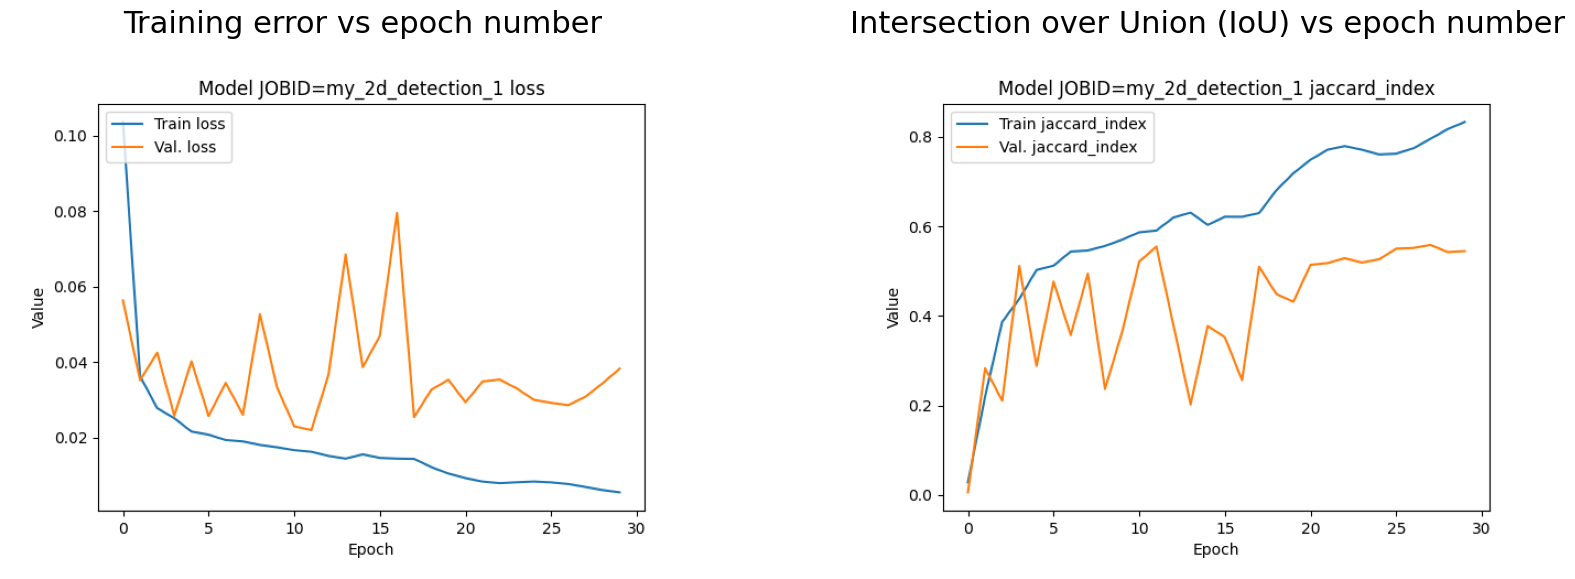

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and IoU vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_jaccard_index.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Intersection over Union (IoU) vs epoch number', fontdict = {'fontsize':22})

## **Visualize detection results**


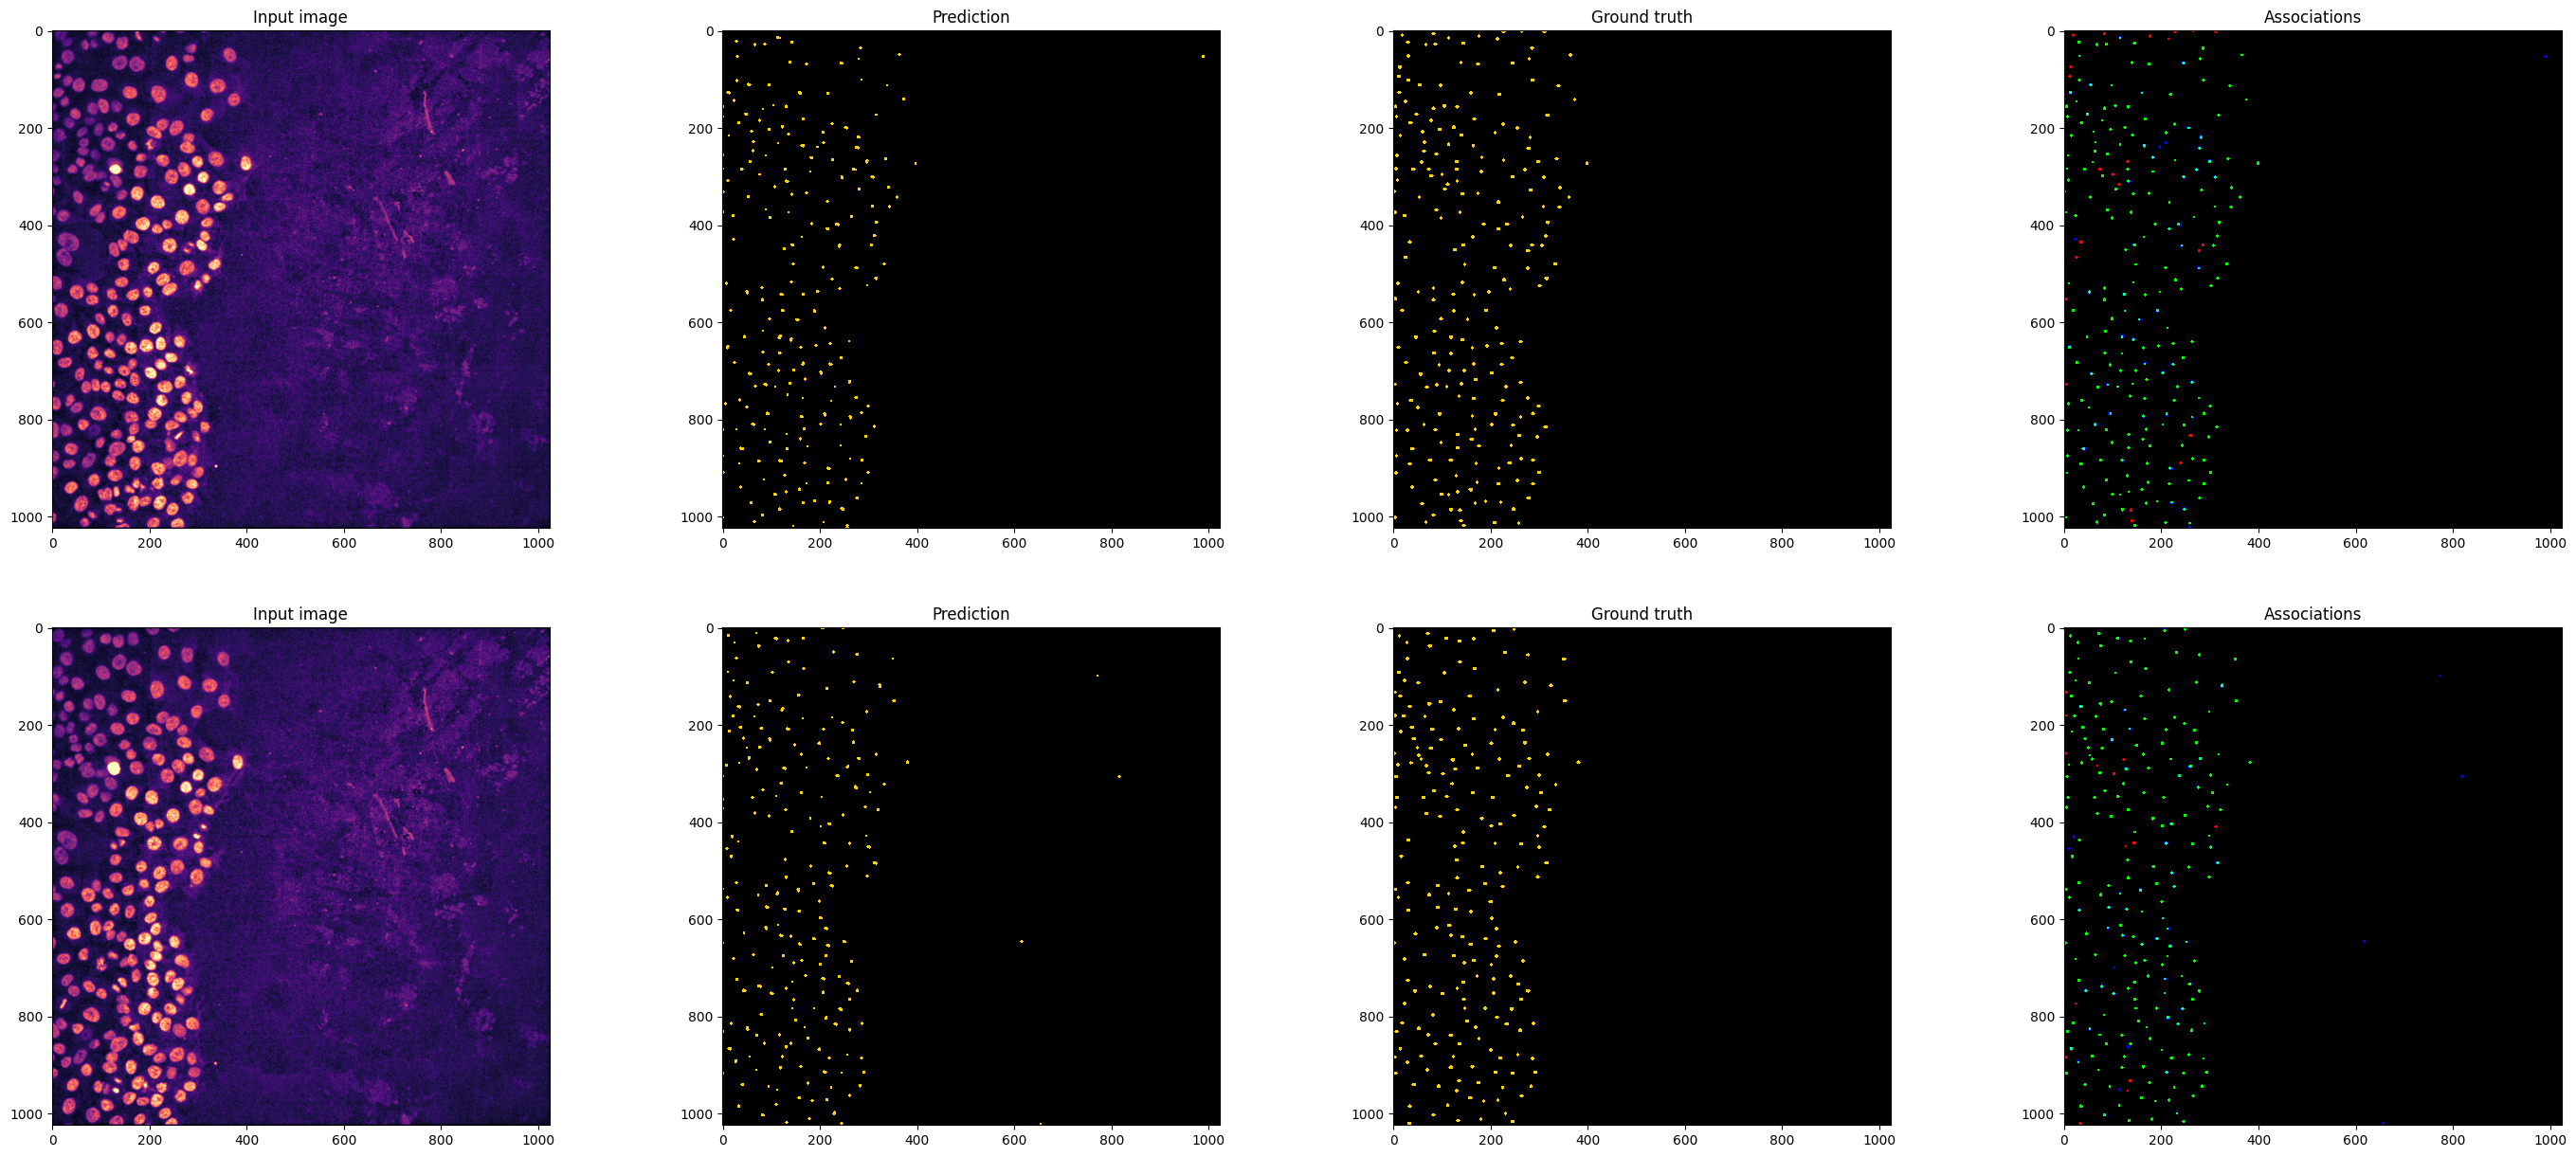

In [ ]:
#@markdown ###Play to visualize results in 2D
#@markdown In the rightmost column (if test_ground_truth = True), associations between predictions and ground truth are illustrated:
#@markdown - **Green**: True positives
#@markdown - **Red**: False negatives
#@markdown - **Blue**: False positives

%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from google.colab import output
output.enable_custom_widget_manager()

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
detection_results = os.path.join(final_results, "per_image_local_max_check")
assoc_results = os.path.join(final_results, "point_associations")
if test_ground_truth:
    test_data_gt_path = os.path.join(test_data_path, "..", "y_detection_masks")

# Show a few examples to check that they have been stored correctly
ids_pred = sorted(next(os.walk(detection_results))[2])
ids_pred = [x for x in ids_pred if not x.endswith('.csv') ]
ids_assoc = sorted(next(os.walk(assoc_results))[2])
ids_assoc = [x for x in ids_assoc if not x.endswith('.csv') ]
ids_assoc = [x for x in ids_assoc if "_gt_ids" not in x ]
ids_assoc = [x for x in ids_assoc if "_pred_ids" not in x ]
ids_input = sorted(next(os.walk(test_data_path))[2])
if test_ground_truth:
    ids_gt = sorted(next(os.walk(test_data_gt_path))[2])

# create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
if test_ground_truth:
    test_sample_assoc = []
    test_sample_gt = []

# read 3D images again
for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(np.squeeze(aux))

    aux = imread(os.path.join(detection_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(np.squeeze(aux))

    if test_ground_truth:
        aux = imread(os.path.join(test_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
        test_sample_gt.append(np.squeeze(aux))

        aux = imread(os.path.join(assoc_results, ids_assoc[chosen_images[i]]))
        test_sample_assoc.append(np.squeeze(aux))

# Show predicted images
fig_size = (35,15) if test_ground_truth else (10,10)
plt.figure(figsize=fig_size)
plt.tight_layout()
index = 0
images_per_row = 4 if test_ground_truth else 2
for j in range(samples_to_show):
    index = index + 1
    plt.subplot(samples_to_show, images_per_row, index)
    plt.title("Input image")
    plt.imshow(test_samples[j], cmap='magma', vmin=np.percentile(test_samples[j],0.1),vmax=np.percentile(test_samples[j],99.9))

    index = index + 1
    plt.subplot(samples_to_show, images_per_row, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap=cmap,  interpolation='nearest')

    if test_ground_truth:
        index = index + 1
        plt.subplot(samples_to_show, images_per_row, index)
        plt.title("Ground truth")
        plt.imshow(test_sample_gt[j],  cmap=cmap, interpolation='nearest')

        index = index + 1
        plt.subplot(samples_to_show, images_per_row, index)
        plt.title("Associations")
        plt.imshow(test_sample_assoc[j], interpolation='nearest')
plt.show()


In [ ]:
#@markdown ###Play to display the path to the output files (one 2D TIFF label image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

detection_results = os.path.join(final_results, "per_image_local_max_check")

print("Output paths:")
print("    Detection files are in {}".format(detection_results))

[13:13:01.307280] Output paths:
[13:13:01.308527]     Detection files are in /content/output/my_2d_detection/results/my_2d_detection_1/per_image_local_max_check


In [ ]:
#@markdown ###Play to display the path to the association files (one 2D TIFF for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

detection_assoc_results = os.path.join(final_results, "point_associations")

print("Output paths:")
print("    Detection files are in {}".format(detection_assoc_results))

Output paths:
    Detection files are in /content/output/my_2d_detection/results/my_2d_detection_1/point_associations


## **Download detection results**

In [ ]:
#@markdown ###Play to download a zip file with all detection results in test.

from google.colab import files

!zip -q -j /content/detection.zip $detection_results/*.tif

files.download("/content/detection.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ### Click to Download a ZIP File with All Detection Association Results from Testing
#@markdown For each test sample, several files are generated:
#@markdown - '*_fn.csv': Contains the false positives (FPs)
#@markdown - '*_gt_assoc.csv': Details the associations between ground truth (GT) and prediction, including both true positives (TP) and false negatives (FN)
#@markdown - '*_gt_ids.tif': Labels for ground truth points
#@markdown - '*_pred_ids.tif': Labels for predicted points
#@markdown - '*.tif': A visual representation of associations between GT and predictions, with colors indicating:
#@markdown   - **Green**: True positives (TP)
#@markdown   - **Red**: False negatives (FN)
#@markdown   - **Blue**: False positives (FP)

from google.colab import files

!zip -q -j /content/detection_associations.zip $detection_assoc_results/*.tif

files.download("/content/detection_associations.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
from google.colab import files

#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = str( job_name ) + '_1-checkpoint-best.pth'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Export your model to BioImage Model Zoo format:**

If you want to export the model into the [BioImage Model Zoo](https://bioimage.io/#/) format, fill the metadata and run the following cell. After the cell is run a `trained_model_name.bmz.zip` file will be downloaded.

In [ ]:

#@markdown ##Construct model's metadata to export it to the BioImage Model Zoo format. Choose just one option:

#@markdown **Option 1: Reuse previous BioImage Model Zoo model configuration**

#@markdown With this option, if you were using a model from BioImage Model Zoo you can select this option to reuse its configuration instead of provide all fields manually. If that's not the case and you try to use this option an error will be thrown.
reuse_previous_BMZ_model_config = False #@param {type:"boolean"}

#@markdown ---

#@markdown **Option 2: Manual export fields**

#@markdown With this option you need to introduce manually the metadata of the model.

# ------------- User input ------------
# information about the model
trained_model_name    = "" #@param {type:"string"}
trained_model_authors =  "[First Author, Second Author, Third Author]" #@param {type:"string"}
trained_model_authors_affiliation =  "[First Author Affiliation, Second Author Affiliation, Third Author Affiliation]" #@param {type:"string"}
trained_model_description = "" #@param {type:"string"}
trained_model_license = 'CC-BY-4.0'#@param {type:"string"}
trained_model_references = ["Ronneberger et al. arXiv in 2015", "Franco-Barranco, Daniel, et al. ISBI in 2023"] #@param {type:"string"}
trained_model_references_DOI = ["10.1007/978-3-319-24574-4_28","10.1109/ISBI53787.2023.10230593"] #@param {type:"string"}
trained_model_tags = "modality: electron-microscopy, content: mitochondria" #@param {type:"string"}
trained_model_documentation = "/content/README.md" #@param {type:"string"}


In [ ]:
#@markdown ###Play to download a zip file with your [BioImage Model Zoo](https://bioimage.io/#/) exported model
# update BMZ export parameters

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
bmz_results = os.path.join(final_results, "bmz_model")

if not reuse_previous_BMZ_model_config:
    from google.colab import files

    # create the author spec input
    auth_names = trained_model_authors[1:-1].split(",")
    auth_affs = trained_model_authors_affiliation[1:-1].split(",")
    assert len(auth_names) == len(auth_affs)
    authors = [{"name": auth_name, "affiliation": auth_aff} for auth_name, auth_aff in zip(auth_names, auth_affs)]

    # create the citation input spec
    assert len(trained_model_references_DOI) == len(trained_model_references)
    citations = [{'text': text, 'doi': doi} for text, doi in zip(trained_model_references, trained_model_references_DOI)]

    tags = [{t.split(":")[0]: t.split(":")[1]} for t in trained_model_tags.split(",")]

    with open(trained_model_documentation, "w") as f:
        f.write("### **Description**\n")
        f.write(f"{trained_model_description}\n\n")
        f.write("This model was created using the [BiaPy library](https://biapyx.github.io/).\n")

    bmz_cfg = {}
    # Description of the model
    bmz_cfg['description'] = trained_model_description
    # Authors of the model. Need to be a list of dicts, e.g. authors=[{"name": "Gizmo"}]
    bmz_cfg['authors'] = authors
    # License of the model. E.g. "CC-BY-4.0"
    bmz_cfg['license'] = trained_model_license
    # List of dictionaries of citations associated, e.g. [{"text": "Gizmo et al.", "doi": "doi:10.1002/xyzacab123"}]
    bmz_cfg['tags'] = tags
    # Tags to make models more findable on the website, e.g. tags=[{'modality': 'electron-microscopy', 'content': 'mitochondria'}]
    bmz_cfg['cite'] = citations
    # Path to a file with a documentation of the model in markdown, e.g. "my-model/doc.md"
    bmz_cfg['doc'] = trained_model_documentation

    biapy.export_model_to_bmz(bmz_results, bmz_cfg)
else:
    biapy.export_model_to_bmz(bmz_results, reuse_original_bmz_config=True)

bmz_zip_path = f"/content/{trained_model_name}.bmz.zip"
if os.path.isdir(bmz_results):
    !zip -r $bmz_zip_path $bmz_results
else:
    print("The model was not exported to this format")

files.download(bmz_zip_path)

## **Advanced options**

### **Adjust detection threshold values**

In [ ]:
#@markdown ### Detection parameters:
min_value_to_be_peak = 0.9 #@param {type:"number"}
tolerance = 10 #@param {type:"number"}
remove_close_points = True #@param {type:"boolean"}
remove_close_points_radius= 3 #@param {type:"number"}


### **Run inference**

In [ ]:
#@markdown ### Play to run inference on test with the new parameters

biapy_config_inference = biapy_config

# set the training to false to peform inference
biapy_config_inference['TRAIN']['ENABLE'] = False

# Detection parameters
biapy_config_inference['TEST']['DET_MIN_TH_TO_BE_PEAK'] = [min_value_to_be_peak]
biapy_config_inference['TEST']['DET_TOLERANCE'] = [tolerance]
biapy_config_inference['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS'] = remove_close_points
biapy_config_inference['TEST']['POST_PROCESSING']['REMOVE_CLOSE_POINTS_RADIUS'] = [remove_close_points_radius]
biapy_config_inference['MODEL']['LOAD_CHECKPOINT'] = True

# save file
inference_file = "/content/"+str(job_name)+"_inference.yaml"

with open( inference_file, 'w') as outfile:
    yaml.dump(biapy_config_inference, outfile, default_flow_style=False)

print( "Inference configuration finished.")

# Run the code
biapy = BiaPy( inference_file, result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()

[13:41:49.711228] Inference configuration finished.
[13:41:49.721989] Date: 2024-02-04 13:41:49
[13:41:49.722103] Arguments: Namespace(config='/content/my_2d_detection_inference.yaml', result_dir='/content/output', name='my_2d_detection', run_id=1, gpu=0, world_size=1, local_rank=-1, dist_on_itp=False, dist_url='env://', dist_backend='nccl')
[13:41:49.723343] Job: my_2d_detection_1
[13:41:49.723400] Python       : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
[13:41:49.723436] PyTorch:  2.1.0+cu121
[13:41:49.726590] Not using distributed mode
[13:41:49.728456] Configuration details:
[13:41:49.730229] AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3

  0%|          | 0/1 [00:00<?, ?it/s]

[13:41:49.923859] Processing image(s): ['cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.tif']
[13:41:49.924574] ### OV-CROP ###
[13:41:49.924648] Cropping (1, 1024, 1024, 1) images into (256, 256, 1) with overlapping. . .
[13:41:49.924684] Minimum overlap selected: (0, 0)
[13:41:49.924719] Padding: (32, 32)
[13:41:49.926539] Real overlapping (%): 0.13020833333333334
[13:41:49.926607] Real overlapping (pixels): 25.0
[13:41:49.926641] 6 patches per (x,y) axis
[13:41:49.934820] **** New data shape is: (36, 256, 256, 1)
[13:41:49.934890] ### END OV-CROP ###




  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 38.47it/s]

                                             

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 48.76it/s]

                                             

[13:41:50.195161] ### MERGE-OV-CROP ###
[13:41:50.195247] Merging (36, 256, 256, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[13:41:50.195282] Minimum overlap selected: (0, 0)
[13:41:50.195313] Padding: (32, 32)
[13:41:50.197819] Real overlapping (%): (0.13020833333333334, 0.13020833333333334)
[13:41:50.197891] Real overlapping (pixels): (25.0, 25.0)
[13:41:50.197926] (6, 6) patches per (x,y) axis
[13:41:50.214756] **** New data shape is: (1, 1024, 1024, 1)
[13:41:50.214852] ### END MERGE-OV-CROP ###
[13:41:50.217071] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                                             

[13:41:50.363396] Capturing the local maxima 
[13:41:50.363487] Class 1
[13:41:50.423274] Removing close points . . .
[13:41:50.424250] Initial number of points: 188
[13:41:50.426274] Final number of points: 166
[13:41:50.426440] Creating the images with detected points . . .
[13:41:50.465699] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:41:50.538478] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image_local_max_check




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:41:50.566591] Reading GT data from: /content/data/test/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image76.csv
[13:41:50.569785] Detection (class 1)
[13:41:50.575957] Points in ground truth: 209, Points in prediction: 166
[13:41:50.576027] True positives: 166, False positives: 0, False negatives: 43
[13:41:50.577336] Detection metrics: ['Precision', 1.0, 'Recall', 0.7942583732057417, 'F1', 0.8853333333333334]
[13:41:50.582487] All classes 1
[13:41:50.582600] Detection metrics: ['Precision', 1.0, 'Recall', 0.7942583732057417, 'F1', 0.8853333333333334]
[13:41:50.582657] Creating the image with a summary of detected points and false positives with colors . . .
[13:41:50.709626] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:41:50.859239] Saving (1, 1, 1024, 1024, 3) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
  0%|          | 0/1 [00:00<?, ?it/s]

[13:41:50.919865] Processing image(s): ['cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.tif']
[13:41:50.920962] ### OV-CROP ###
[13:41:50.921055] Cropping (1, 1024, 1024, 1) images into (256, 256, 1) with overlapping. . .
[13:41:50.921098] Minimum overlap selected: (0, 0)
[13:41:50.921130] Padding: (32, 32)
[13:41:50.922726] Real overlapping (%): 0.13020833333333334
[13:41:50.922802] Real overlapping (pixels): 25.0
[13:41:50.922835] 6 patches per (x,y) axis
[13:41:50.931065] **** New data shape is: (36, 256, 256, 1)
[13:41:50.931137] ### END OV-CROP ###




  0%|          | 0/5 [00:00<?, ?it/s]

                                     

  0%|          | 0/5 [00:00<?, ?it/s]

                                     

[13:41:51.140196] ### MERGE-OV-CROP ###
[13:41:51.140272] Merging (36, 256, 256, 1) images into (1, 1024, 1024, 1) with overlapping . . .
[13:41:51.140302] Minimum overlap selected: (0, 0)
[13:41:51.140330] Padding: (32, 32)
[13:41:51.146116] Real overlapping (%): (0.13020833333333334, 0.13020833333333334)
[13:41:51.146196] Real overlapping (pixels): (25.0, 25.0)
[13:41:51.147329] (6, 6) patches per (x,y) axis
[13:41:51.158658] **** New data shape is: (1, 1024, 1024, 1)
[13:41:51.158736] ### END MERGE-OV-CROP ###
[13:41:51.160621] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  9.71it/s]

                                             

[13:41:51.297170] Capturing the local maxima 
[13:41:51.298111] Class 1
[13:41:51.354385] Removing close points . . .
[13:41:51.354483] Initial number of points: 194
[13:41:51.357020] Final number of points: 170
[13:41:51.357182] Creating the images with detected points . . .
[13:41:51.395351] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:41:51.463042] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/per_image_local_max_check




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:41:51.489120] Reading GT data from: /content/data/test/y/cell migration R1 - Position 58_XY1562686154_Z0_T00_C1-image86.csv
[13:41:51.492194] Detection (class 1)
[13:41:51.498411] Points in ground truth: 226, Points in prediction: 170
[13:41:51.498493] True positives: 170, False positives: 0, False negatives: 56
[13:41:51.498566] Detection metrics: ['Precision', 1.0, 'Recall', 0.7522123893805309, 'F1', 0.8585858585858585]
[13:41:51.506841] All classes 1
[13:41:51.507546] Detection metrics: ['Precision', 1.0, 'Recall', 0.7522123893805309, 'F1', 0.8585858585858585]
[13:41:51.507602] Creating the image with a summary of detected points and false positives with colors . . .
[13:41:51.629311] Saving (1, 1, 1024, 1024, 1) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     

[13:41:51.778820] Saving (1, 1, 1024, 1024, 3) data as .tif in folder: /content/output/my_2d_detection/results/my_2d_detection_1/point_associations




  0%|          | 0/1 [00:00<?, ?it/s]

                                     
100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

[13:41:51.819385] Releasing memory . . .
[13:41:51.819523] #############
[13:41:51.819576] #  RESULTS  #
[13:41:51.819798] #############
[13:41:51.820148] Loss (per patch): 0.09626651555299759
[13:41:51.820224] Test Foreground IoU (per patch): 0.07162842278679211
[13:41:51.820253]  
[13:41:51.820294] Test Foreground IoU (merge patches): 0.593855881329747
[13:41:51.820324] Test Overall IoU (merge patches): 0.7948316380477902
[13:41:51.820364]  
[13:41:51.820395] Detection specific metrics:
[13:41:51.820433] Detection - Test Precision (merge patches): 1.0
[13:41:51.820469] Detection - Test Recall (merge patches): 0.7732353812931363
[13:41:51.820497] Detection - Test F1 (merge patches): 0.8719595959595959
[13:41:51.820561] FINISHED JOB my_2d_detection_1 !!


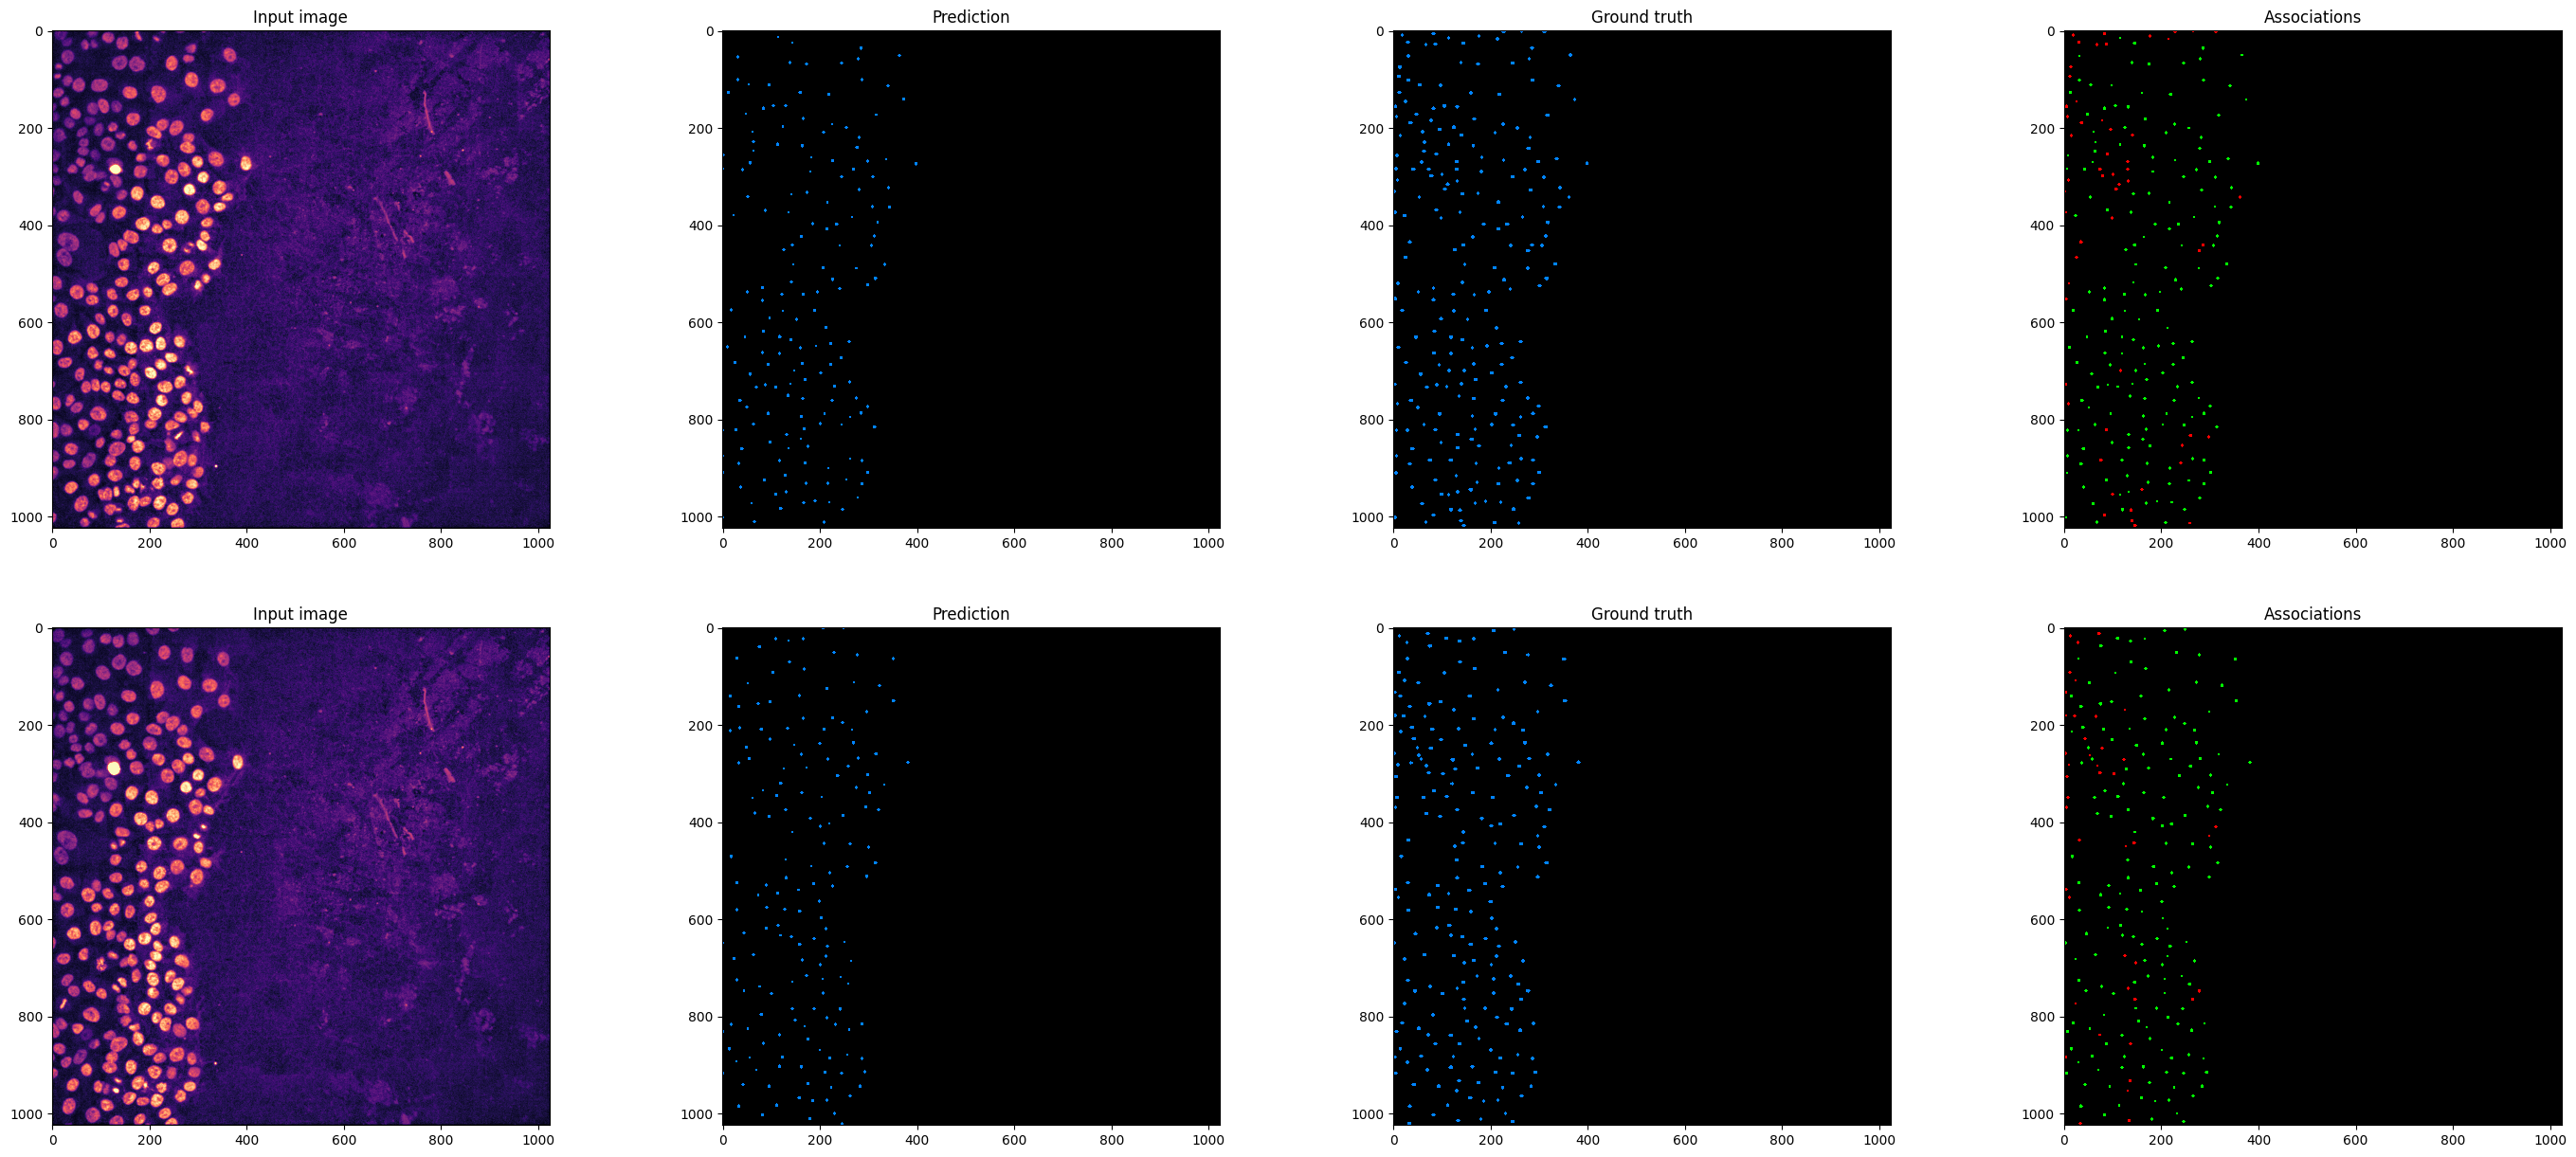

In [ ]:
#@markdown ###Play to visualize results in 2D
#@markdown In the rightmost column (if test_ground_truth = True), associations between predictions and ground truth are illustrated:
#@markdown - **Green**: True positives
#@markdown - **Red**: False negatives
#@markdown - **Blue**: False positives

%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from google.colab import output
output.enable_custom_widget_manager()

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
detection_results = os.path.join(final_results, "per_image_local_max_check")
assoc_results = os.path.join(final_results, "point_associations")
if test_ground_truth:
    test_data_gt_path = os.path.join(test_data_path, "..", "y_detection_masks")

# Show a few examples to check that they have been stored correctly
ids_pred = sorted(next(os.walk(detection_results))[2])
ids_pred = [x for x in ids_pred if not x.endswith('.csv') ]
ids_assoc = sorted(next(os.walk(assoc_results))[2])
ids_assoc = [x for x in ids_assoc if not x.endswith('.csv') ]
ids_assoc = [x for x in ids_assoc if "_gt_ids" not in x ]
ids_assoc = [x for x in ids_assoc if "_pred_ids" not in x ]
ids_input = sorted(next(os.walk(test_data_path))[2])
if test_ground_truth:
    ids_gt = sorted(next(os.walk(test_data_gt_path))[2])

# create random color map
vals = np.linspace(0,1,256)
np.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.gist_rainbow(vals))
cmap.colors[0] = [0., 0., 0., 1.] # set background to black

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
if test_ground_truth:
    test_sample_assoc = []
    test_sample_gt = []

# read 3D images again
for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(np.squeeze(aux))

    aux = imread(os.path.join(detection_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(np.squeeze(aux))

    if test_ground_truth:
        aux = imread(os.path.join(test_data_gt_path, ids_gt[chosen_images[i]])).astype(np.uint16)
        test_sample_gt.append(np.squeeze(aux))

        aux = imread(os.path.join(assoc_results, ids_assoc[chosen_images[i]]))
        test_sample_assoc.append(np.squeeze(aux))

# Show predicted images
fig_size = (35,15) if test_ground_truth else (10,10)
plt.figure(figsize=fig_size)
plt.tight_layout()
index = 0
images_per_row = 4 if test_ground_truth else 2
for j in range(samples_to_show):
    index = index + 1
    plt.subplot(samples_to_show, images_per_row, index)
    plt.title("Input image")
    plt.imshow(test_samples[j], cmap='magma', vmin=np.percentile(test_samples[j],0.1),vmax=np.percentile(test_samples[j],99.9))

    index = index + 1
    plt.subplot(samples_to_show, images_per_row, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap=cmap,  interpolation='nearest')

    if test_ground_truth:
        index = index + 1
        plt.subplot(samples_to_show, images_per_row, index)
        plt.title("Ground truth")
        plt.imshow(test_sample_gt[j],  cmap=cmap, interpolation='nearest')

        index = index + 1
        plt.subplot(samples_to_show, images_per_row, index)
        plt.title("Associations")
        plt.imshow(test_sample_assoc[j], interpolation='nearest')
plt.show()


## **Acknowledgments**

We extend our gratitude to the [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki) for their invaluable inspiration. Notably, we have adopted some of their descriptions concerning metrics and parameters.